# Capstone Project - Segmenting & Clustering Neighbourhoods in Toronto - Part 3

Author : Avinandan Mukherjee

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


## Performing steps again from Part 1 to build the dataframe again

In [2]:
url ='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df_Toronto =pd.read_html(url)
df_Toronto[0].to_csv('toronto.csv')
df_Toronto =pd.read_csv('toronto.csv')
df_Toronto.head()

,Unnamed: 0,Postal Code,Borough,Neighbourhood
0,0,M1A,Not assigned,Not assigned
1,1,M2A,Not assigned,Not assigned
2,2,M3A,North York,Parkwoods
3,3,M4A,North York,Victoria Village
4,4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [3]:
# Dropping unwanted columns from the dataset
df_Toronto.drop('Unnamed: 0',inplace =True, axis =1)
df_Toronto.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [4]:
df_Toronto['Borough'].replace({'Not assigned':np.NaN},inplace =True)
df_Toronto.dropna(inplace =True)
df_Toronto =df_Toronto.reset_index(drop=True)
df_Toronto.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [5]:
df_Toronto.shape

(103, 3)

## Performing steps again from Part 2 to add Geospatial data to the pre-processed dataset

Using the given link to a csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_data

In [6]:
#adding lat & long for the postal code
!wget -q -O 'Geospatial_data.csv'  https://cocl.us/Geospatial_data
df_GeoLocation = pd.read_csv('Geospatial_data.csv')
df_GeoLocation.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merging the Toronto dataset and Geolocation dataset with mapped Postal Codes as join key in both the tables.

In [11]:
df_Toronto =df_Toronto.sort_values('Postal Code').reset_index()

In [12]:
df_Toronto.drop('index',inplace =True,axis =1)

In [13]:
df_Toronto =pd.merge(df_Toronto, df_GeoLocation, on ='Postal Code')

In [14]:
df_Toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Part 3 : Start here

### Part 3 : Obeservations, Analysis with generting Map

In [15]:
# List of Boroughs in Canada
df_Toronto['Borough'].unique().tolist()

['Scarborough',
 'North York',
 'East York',
 'East Toronto',
 'Central Toronto',
 'Downtown Toronto',
 'York',
 'West Toronto',
 'Mississauga',
 'Etobicoke']

Creating a map of Toronto with neighborhoods superimposed on top

In [16]:
!pip install folium
print('Folium ready to import')

     |████████████████████████████████| 93 kB 4.8 MB/s  eta 0:00:01
Folium ready to import


In [17]:
# Geo Coordinates of Toronto
address = 'Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Creating a map of Toronto with neighborhoods superimposed on top

In [18]:
toronto_lat,toronto_long =43.6534817, -79.3839347 # Lat & Long values copied from above

In [19]:
import folium
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[toronto_lat,toronto_long], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_Toronto['Latitude'], df_Toronto['Longitude'], df_Toronto['Borough'], df_Toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#87cefa',
        fill_opacity=0.5,
        parse_html=False).add_to(map_Toronto)

In [20]:
map_Toronto

Reducing the neighbours to target analysis of Toronto area only for when Borough contains Toronto.

In [21]:
df_TorontoPC = df_Toronto
df_TorontoData = df_TorontoPC.drop("Postal Code", axis=1)
df_TorontoData.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


In [22]:
df_TorontoDataOnly = df_TorontoData[df_TorontoData['Borough'].str.contains("Toronto")].reset_index(drop=True)
print(df_TorontoDataOnly.shape)
df_TorontoDataOnly

(39, 4)


,Borough,Neighbourhood,Latitude,Longitude
0,East Toronto,The Beaches,43.676357,-79.293031
1,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,East Toronto,Studio District,43.659526,-79.340923
4,Central Toronto,Lawrence Park,43.728020,-79.388790
5,Central Toronto,Davisville North,43.712751,-79.390197
6,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
7,Central Toronto,Davisville,43.704324,-79.388790
8,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
9,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049


#### Exploring Neighbourhood in Toronto

Using the following foursquare api query url, search venues on all boroughs in selected Toronto neighborhoods https://api.foursquare.com/v2/venues/search?client_id=CLIENT_ID&client_secret=CLIENT_SECRET&ll=LATITUDE,LONGITUDE&v=VERSION&query=QUERY&radius=RADIUS&limit=LIMIT

In [79]:
# Utilizing FourSquare API to explore the neighbourhood and segment them
CLIENT_ID = 'RFQ..........................................YDC5MB1' # your Foursquare ID
CLIENT_SECRET = 'YQOP............................................2NO2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RFQ..........................................YDC5MB1
CLIENT_SECRET:YQOP............................................2NO2


In [24]:
# Exploring the first neighbourhood in our dataframe
df_TorontoDataOnly.loc[0, 'Neighbourhood']

'The Beaches'

In [25]:
# Get the  first neighborhood's latitude and longitude values
neighbourhood_latitude = df_TorontoDataOnly.loc[0, 'Latitude'] # neighbourhood latitude value
neighbourhood_longitude = df_TorontoDataOnly.loc[0, 'Longitude'] # neighbourhood longitude value

neighbourhood_name = df_TorontoDataOnly.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of The Beaches are 43.67635739999999, -79.2930312.


Using Foursquare API to get a list of all the venues in all the boroughs and store them in the DataFrame with respective geospatial coordinates.

In [26]:
import requests
from pandas.io.json import json_normalize

In [27]:
#Function to store the venues in the dataframe
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [78]:
# Retrieve list of Toronto venues
df_TorontoVenues =getNearbyVenues(names =df_Toronto['Neighbourhood'],
                              latitudes =df_Toronto['Latitude'],
                              longitudes =df_Toronto['Longitude']
                                 )

# my Foursquare API stared throwing me some errors starting today. So some exploration quries thrwoing error. 
# I have also reset my client secret and updated it but no luck. So my consecutive queries are not running as well.
# I have also tried to run the those queries after restarting the kernel, but no luck. Refer Clustering Neighbouhoods at the end for the same.


Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [29]:
df_TorontoVenues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Malvern, Rouge",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [30]:
# List of all unique venues catagory in Toronto
df_TorontoVenues['Venue Category'].unique().tolist()

['Fast Food Restaurant',
 'Print Shop',
 'Bar',
 'Bank',
 'Electronics Store',
 'Restaurant',
 'Mexican Restaurant',
 'Rental Car Location',
 'Medical Center',
 'Intersection',
 'Breakfast Spot',
 'Coffee Shop',
 'Korean BBQ Restaurant',
 'Pharmacy',
 'Caribbean Restaurant',
 'Hakka Restaurant',
 'Thai Restaurant',
 'Athletics & Sports',
 'Gas Station',
 'Bakery',
 'Lounge',
 'Fried Chicken Joint',
 'Playground',
 'Department Store',
 'Convenience Store',
 'Discount Store',
 'Hobby Shop',
 'Ice Cream Shop',
 'Bus Line',
 'Metro Station',
 'Bus Station',
 'Park',
 'Soccer Field',
 'Motel',
 'American Restaurant',
 'Skating Rink',
 'Café',
 'General Entertainment',
 'College Stadium',
 'Chinese Restaurant',
 'Indian Restaurant',
 'Vietnamese Restaurant',
 'Pet Store',
 'Sandwich Place',
 'Middle Eastern Restaurant',
 'Shopping Mall',
 'Auto Garage',
 'Latin American Restaurant',
 'Italian Restaurant',
 'Noodle House',
 'Pizza Place',
 'Grocery Store',
 'Camera Store',
 'Golf Course',
 'P

In [31]:
#Individual Count of values for unique venue catagory in Toronto
df_TorontoVenues['Venue Category'].value_counts()

Coffee Shop                        190
Café                                94
Restaurant                          64
Park                                55
Pizza Place                         48
Hotel                               45
Italian Restaurant                  44
Sandwich Place                      40
Japanese Restaurant                 40
Bakery                              38
Clothing Store                      35
Gym                                 32
Fast Food Restaurant                31
Sushi Restaurant                    31
Grocery Store                       29
American Restaurant                 26
Bar                                 26
Bank                                26
Seafood Restaurant                  25
Thai Restaurant                     24
Pub                                 23
Breakfast Spot                      21
Pharmacy                            20
Bookstore                           18
Gastropub                           18
Beer Bar                 

In [33]:
# Count of distinct values for unique venues in Toronto
countVenues = df_TorontoVenues['Venue Category'].nunique()
print("There are",countVenues," unique venues in Toronto.")

There are 274  unique venues in Toronto.


In [37]:
# Count of venues were returned for each Boroug 
df_TorontoVenues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",6,6,6,6,6,6
"Bathurst Manor, Wilson Heights, Downsview North",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
Berczy Park,58,58,58,58,58,58
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",17,17,17,17,17,17


In [36]:
# Check sized of resulting dataframe
print(df_TorontoVenues.shape)
df_TorontoVenues.head()

(2138, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Malvern, Rouge",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [38]:
print('There are {} uniques categories.'.format(len(df_TorontoVenues['Venue Category'].unique())))

There are 274 uniques categories.


#### Analyze each Borough Neighbourhood - Clustering Neighbourhoods

In [40]:
# one hot encoding to anaylyze the occurence of the top ten venues in each neighbourhood
toronto_onehot1 =pd.get_dummies(df_TorontoVenues[['Venue Category']],prefix ='',prefix_sep='')
toronto_onehot1.pop('Neighborhood')
toronto_onehot1.insert(0,'Neighborhood',df_TorontoVenues['Neighborhood'])
toronto_onehot1.head()

,Neighborhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [41]:
# confirm the new size
toronto_onehot1.shape

(2138, 274)

In [43]:
toronto_grouped =toronto_onehot1.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0

In [44]:
#Check new size:
toronto_grouped.shape

(95, 274)

In [46]:
# Print each neighborhood along with the top 5 most common venues
num_top_venues = 5
for neigh in toronto_grouped['Neighborhood']:
    print("----"+neigh+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == neigh].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0               Skating Rink  0.25
1                     Lounge  0.25
2             Breakfast Spot  0.25
3  Latin American Restaurant  0.25
4          Accessories Store  0.00


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.33
1             Gym  0.17
2             Pub  0.17
3     Coffee Shop  0.17
4  Sandwich Place  0.17


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                Coffee Shop  0.10
1                       Bank  0.10
2          Convenience Store  0.05
3  Middle Eastern Restaurant  0.05
4              Shopping Mall  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1  Japanese Restaurant  0.25
2                 Bank  0.25
3   Chinese Restaurant  0.25
4                Motel  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0      Sandwich Place  0.09
1  Italian Restaurant  0.09

In [47]:
def return_most_common_venues(row, num_top_ten):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_ten]

In [49]:
num_top_ten =10
indicators =['st','nd','rd']
columns =['Neighborhood']
for inp in np.arange(num_top_ten):
    try:
        columns.append('{}{} Most Common Venue'.format(inp+1, indicators[inp]))
    except:
        columns.append('{}th Most Common Venue'.format(inp+1))

toronto_venue_sorted = pd.DataFrame(columns=columns)
toronto_venue_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_venue_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_ten)

toronto_venue_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Skating Rink,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,"Alderwood, Long Branch",Pizza Place,Gym,Coffee Shop,Sandwich Place,Pub,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Sandwich Place,Supermarket,Sushi Restaurant,Middle Eastern Restaurant,Deli / Bodega,Ice Cream Shop,Fried Chicken Joint,Frozen Yogurt Shop
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Yoga Studio,Doner Restaurant,Discount Store,Distribution Center,Dog Run,Donut Shop
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Thai Restaurant,Sandwich Place,Liquor Store,Pizza Place,Restaurant,Sushi Restaurant,Indian Restaurant,Pub


#### Clustering Neighbourhoods

Run the k-means t cluster the neighbourhood into 6 clusters.

In [50]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [51]:
print(len(kmeans.labels_))

95


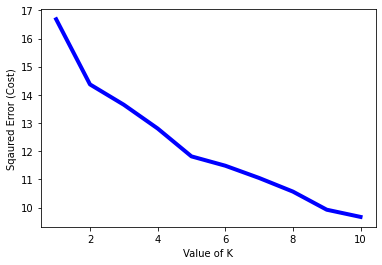

In [53]:
# determine the best k for the dataset by impleminting the elbow method and silhouette method for determining k

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

toronto_grouped_clustering =toronto_grouped.drop('Neighborhood',1)
cost =[] 
#elbow method for determining k
for i in range(1,11):
    KM = KMeans(n_clusters = i,random_state=3) 
    KM.fit(toronto_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='b', linewidth ='4') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()

In [54]:
# Since elbow point is approx near k

# silhouette method for confirming k
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k,random_state=3).fit(toronto_grouped_clustering)
  labels = kmeans.labels_
  sil.append(silhouette_score(toronto_grouped_clustering, labels, metric = 'euclidean'))

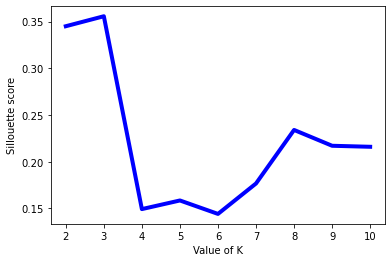

In [55]:
sil
plt.plot(range(2, kmax+1),sil,color ='b',linewidth ='4')
plt.xlabel("Value of K") 
plt.ylabel("Sillouette score") 
plt.show()

In [56]:
# The highest silhouette seems to be near k=3

k = 3
kmean =KMeans(n_clusters = k,random_state=3).fit(toronto_grouped_clustering)
kmean.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2,
       1, 2, 1, 1, 1, 1, 2], dtype=int32)

In [73]:
toronto_venue_sorted(0, 'Cluster Labels', kmean.labels_).reset_index(drop=True)

TypeError: 'DataFrame' object is not callable

In [71]:
toronto_venue_sorted.insert(0,'Cluster Labels',kmean.labels_)
toronto_merged = df_Toronto
toronto_merged = toronto_merged.join(toronto_venue_sorted.set_index('Neighborhood'),on='Neighbourhood')
toronto_merged.head()

ValueError: cannot insert Cluster Labels, already exists

In [61]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

KeyError: 'Cluster Labels'

In [77]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'],toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

KeyError: 'Cluster Labels'

In [63]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_TorontoData['Latitude'], df_TorontoData['Longitude'], df_TorontoData['Neighbourhood'],kmeans.labels_):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

IndexError: list index out of range